<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/03_vit_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Transformer

In [ ]:
!pip install timm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Proyecto_PTI")

import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"

from prepare_dataset import prepare_dataloaders_kaggle, load_clean_split_kaggle

# 1) Con data augmentation
train_loader_aug, val_loader_aug, test_loader_aug, classes = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=True
)

# 2) Sin data augmentation
train_loader_noaug, val_loader_noaug, test_loader_noaug, _ = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=False
)

classes


Mounted at /content/drive
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

🔢 Mapeo clase → índice: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Usando DATA AUGMENTATION en entrenamiento
Clases detectadas: ['glioma', 'meningioma', 'notu

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader)
    acc = correct / len(loader.dataset)
    return avg_loss, acc


def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader)
    acc = correct / len(loader.dataset)
    return avg_loss, acc


In [ ]:
def create_vit_model(num_classes):
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=num_classes,
        drop_rate=0.1,
        drop_path_rate=0.1
    )
    return model.to(device)


In [ ]:
vit_aug = create_vit_model(len(classes))

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.AdamW(vit_aug.parameters(), lr=3e-5, weight_decay=1e-2)

scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_aug, mode="min", factor=0.1, patience=3
)

EPOCHS = 10  # puedes ajustar según tiempo

history_aug = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

best_val_loss_aug = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(vit_aug, train_loader_aug, optimizer_aug, criterion)
    val_loss, val_acc     = eval_one_epoch(vit_aug, val_loader_aug, criterion)

    history_aug["train_loss"].append(train_loss)
    history_aug["val_loss"].append(val_loss)
    history_aug["train_acc"].append(train_acc)
    history_aug["val_acc"].append(val_acc)

    scheduler_aug.step(val_loss)

    print(f"\n[ViT-AUG] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_aug:
        best_val_loss_aug = val_loss
        torch.save(vit_aug.state_dict(), "/content/drive/MyDrive/Proyecto_PTI/vit_aug_best.pth")
        print("  ✔ Mejor modelo ViT-AUG guardado")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


[ViT-AUG] Epoch 1/10
  Train Loss: 0.4538 | Train Acc: 0.8256
  Val   Loss: 0.2595   | Val   Acc: 0.8959
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 2/10
  Train Loss: 0.2033 | Train Acc: 0.9299
  Val   Loss: 0.1197   | Val   Acc: 0.9594
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 3/10
  Train Loss: 0.1195 | Train Acc: 0.9543
  Val   Loss: 0.0686   | Val   Acc: 0.9742
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 4/10
  Train Loss: 0.0865 | Train Acc: 0.9705
  Val   Loss: 0.0761   | Val   Acc: 0.9732

[ViT-AUG] Epoch 5/10
  Train Loss: 0.0666 | Train Acc: 0.9768
  Val   Loss: 0.0508   | Val   Acc: 0.9822
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 6/10
  Train Loss: 0.0548 | Train Acc: 0.9819
  Val   Loss: 0.0334   | Val   Acc: 0.9901
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 7/10
  Train Loss: 0.0613 | Train Acc: 0.9800
  Val   Loss: 0.0307   | Val   Acc: 0.9901
  ✔ Mejor modelo ViT-AUG guardado

[ViT-AUG] Epoch 8/10
  Train Loss: 0.0558 | Train Acc

In [ ]:
vit_noaug = create_vit_model(len(classes))

criterion = nn.CrossEntropyLoss()
optimizer_noaug = optim.AdamW(vit_noaug.parameters(), lr=3e-5, weight_decay=1e-2)

scheduler_noaug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_noaug, mode="min", factor=0.1, patience=3
)

history_noaug = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

best_val_loss_noaug = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(vit_noaug, train_loader_noaug, optimizer_noaug, criterion)
    val_loss, val_acc     = eval_one_epoch(vit_noaug, val_loader_noaug, criterion)

    history_noaug["train_loss"].append(train_loss)
    history_noaug["val_loss"].append(val_loss)
    history_noaug["train_acc"].append(train_acc)
    history_noaug["val_acc"].append(val_acc)

    scheduler_noaug.step(val_loss)

    print(f"\n[ViT-NO-AUG] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_noaug:
        best_val_loss_noaug = val_loss
        torch.save(vit_noaug.state_dict(), "/content/drive/MyDrive/Proyecto_PTI/vit_noaug_best.pth")
        print("  ✔ Mejor modelo ViT-NO-AUG guardado")



[ViT-NO-AUG] Epoch 1/10
  Train Loss: 0.3446 | Train Acc: 0.8709
  Val   Loss: 0.0852   | Val   Acc: 0.9693
  ✔ Mejor modelo ViT-NO-AUG guardado

[ViT-NO-AUG] Epoch 2/10
  Train Loss: 0.0954 | Train Acc: 0.9701
  Val   Loss: 0.1159   | Val   Acc: 0.9574

[ViT-NO-AUG] Epoch 3/10
  Train Loss: 0.0503 | Train Acc: 0.9832
  Val   Loss: 0.0667   | Val   Acc: 0.9742
  ✔ Mejor modelo ViT-NO-AUG guardado

[ViT-NO-AUG] Epoch 4/10
  Train Loss: 0.0227 | Train Acc: 0.9917
  Val   Loss: 0.1176   | Val   Acc: 0.9623

[ViT-NO-AUG] Epoch 5/10
  Train Loss: 0.0213 | Train Acc: 0.9932
  Val   Loss: 0.0464   | Val   Acc: 0.9841
  ✔ Mejor modelo ViT-NO-AUG guardado

[ViT-NO-AUG] Epoch 6/10
  Train Loss: 0.0131 | Train Acc: 0.9947
  Val   Loss: 0.0677   | Val   Acc: 0.9782

[ViT-NO-AUG] Epoch 7/10
  Train Loss: 0.0173 | Train Acc: 0.9936
  Val   Loss: 0.0612   | Val   Acc: 0.9851

[ViT-NO-AUG] Epoch 8/10
  Train Loss: 0.0046 | Train Acc: 0.9983
  Val   Loss: 0.0744   | Val   Acc: 0.9832

[ViT-NO-AUG] Epo

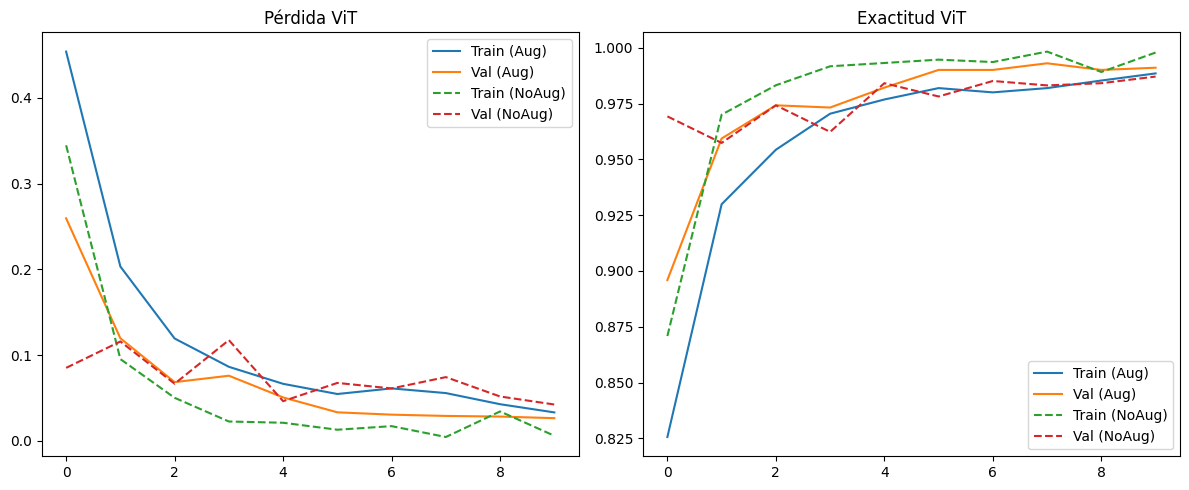

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_aug["train_loss"], label="Train (Aug)")
plt.plot(history_aug["val_loss"],   label="Val (Aug)")
plt.plot(history_noaug["train_loss"], label="Train (NoAug)", linestyle="--")
plt.plot(history_noaug["val_loss"],   label="Val (NoAug)", linestyle="--")
plt.title("Pérdida ViT")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_aug["train_acc"], label="Train (Aug)")
plt.plot(history_aug["val_acc"],   label="Val (Aug)")
plt.plot(history_noaug["train_acc"], label="Train (NoAug)", linestyle="--")
plt.plot(history_noaug["val_acc"],   label="Val (NoAug)", linestyle="--")
plt.title("Exactitud ViT")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
vit_aug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/vit_aug_best.pth"))
vit_noaug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/vit_noaug_best.pth"))


<All keys matched successfully>

In [ ]:
test_loss_aug, test_acc_aug = eval_one_epoch(vit_aug, test_loader_aug, criterion)
test_loss_noaug, test_acc_noaug = eval_one_epoch(vit_noaug, test_loader_noaug, criterion)

print(f"ViT CON Augmentation -> Test Loss: {test_loss_aug:.4f} | Test Acc: {test_acc_aug:.4f}")
print(f"ViT SIN Augmentation -> Test Loss: {test_loss_noaug:.4f} | Test Acc: {test_acc_noaug:.4f}")


ViT CON Augmentation -> Test Loss: 0.0194 | Test Acc: 0.9941
ViT SIN Augmentation -> Test Loss: 0.0386 | Test Acc: 0.9901


In [ ]:
def get_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()

            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)


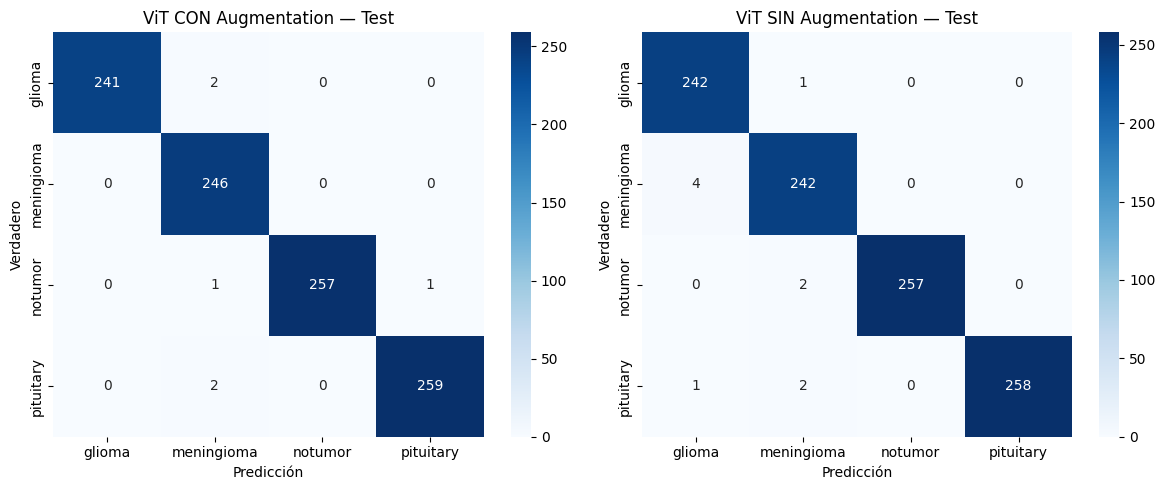

In [ ]:
y_true_aug, y_pred_aug = get_preds(vit_aug, test_loader_aug)
y_true_noaug, y_pred_noaug = get_preds(vit_noaug, test_loader_noaug)

cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
cm_noaug = confusion_matrix(y_true_noaug, y_pred_noaug)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("ViT CON Augmentation — Test")
plt.xlabel("Predicción"); plt.ylabel("Verdadero")

plt.subplot(1,2,2)
sns.heatmap(cm_noaug, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("ViT SIN Augmentation — Test")
plt.xlabel("Predicción"); plt.ylabel("Verdadero")

plt.tight_layout()
plt.show()


In [ ]:
print("=== ViT CON Augmentation ===")
print(classification_report(y_true_aug, y_pred_aug, target_names=classes))

print("\n=== ViT SIN Augmentation ===")
print(classification_report(y_true_noaug, y_pred_noaug, target_names=classes))


=== ViT CON Augmentation ===
              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       243
  meningioma       0.98      1.00      0.99       246
     notumor       1.00      0.99      1.00       259
   pituitary       1.00      0.99      0.99       261

    accuracy                           0.99      1009
   macro avg       0.99      0.99      0.99      1009
weighted avg       0.99      0.99      0.99      1009


=== ViT SIN Augmentation ===
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       243
  meningioma       0.98      0.98      0.98       246
     notumor       1.00      0.99      1.00       259
   pituitary       1.00      0.99      0.99       261

    accuracy                           0.99      1009
   macro avg       0.99      0.99      0.99      1009
weighted avg       0.99      0.99      0.99      1009



In [ ]:
torch.save(vit_aug.state_dict(), "vit_aug_final.pth")
torch.save(vit_noaug.state_dict(), "vit_noaug_final.pth")
